# DATA515 Yelp Reviews

## Visualization Example using MapBox

### Objective:

Yelp search does not allow for simple filtered search by ratings- can we build an intuitive, interactive map that allows users to search for restaurants given a ratings range? 
What other filters can be added?

Further, given Yelp's rich text data, what sort of insights can be gained from their reviews?  

- Can ratings be predicted from review text?
- Can we extract keywords from the reviews?
- How accurate are the restaurant searches? (A search for "tacos" in Seattle returns restaurants that aren't even marginally related to tacos, for example"

The text processing and learning portion of this project has been shelved mostly as a next step project.

### Generating Maps
#### Step 1: Build interactive map using MapBox

In [1]:
#Imports

import os
from pathlib import Path

import pandas as pd
import numpy as np

from mapboxgl.utils import create_color_stops, df_to_geojson
from mapboxgl.viz import CircleViz

import sys
import re

import ipywidgets as widgets

import nltk
import collections

import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud, STOPWORDS

sys.path.append(str(Path(os.getcwd()).parents[0]))

from yelp_reviews import (
    get_viz, 
    get_latest_reviews, 
    read_all_reviews,
    preprocess, 
    get_rare_words
)

import yelp_reviews

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
#read token for MapBox, API key for Yelp Fusion API

def read_api_key():
    dir_path = str(Path(os.getcwd()).parents[0])
    api_key = Path(os.path.join(dir_path, "yelp_reviews", 
                                "api_key.txt")).read_text()
    return api_key

api_key = read_api_key()
#print(read_api_key())

In [3]:
#read data from prepared .csv file
#The parameters for this search was "Tacos" in "University District, Seattle"

dir_path = str(Path(os.getcwd()).parents[0])
file_path = Path(os.path.join(dir_path, "data", "api_data.csv"))

In [4]:
#Set API search parameters.
#Example search: Tacos in UDistrict

params = {"term" : "tacos",
          "location" : "University District, Seattle",
          "categories" : "restaurants"}

In [5]:
#prepare mapBox map

viz = get_viz(file_path)

#render map

viz.show()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


The Yelp API returned 156 restaurants in the UDistrict area with keyword "Tacos".

As we can see from the map above, while some restaurants that were marginally taco-like, there are others which seemingly has little to do with tacos (Chowders??) 

We'll examine the tagged keywords in the "category" field returned from the API.

In [6]:
#Example- see the actual restaurant categories of the returned API call for "Tacos"

df = pd.read_csv(file_path)

cat_list = []

for i in range(len(df)):
    cat_item = df["category"][i].split(",")
    cat_list.append(cat_item)
    
cat_list_flat = []
    
for j in cat_list:
    cat_list_flat += j
    
cat_counter = collections.Counter(cat_list_flat)

df_counter = pd.DataFrame.from_dict(
    cat_counter, orient = 'index').reset_index().rename(
    columns={"index":"category", 0:"count"})

df_counter = df_counter.sort_values(by = "count", ascending = False)

<AxesSubplot:xlabel='count', ylabel='category'>

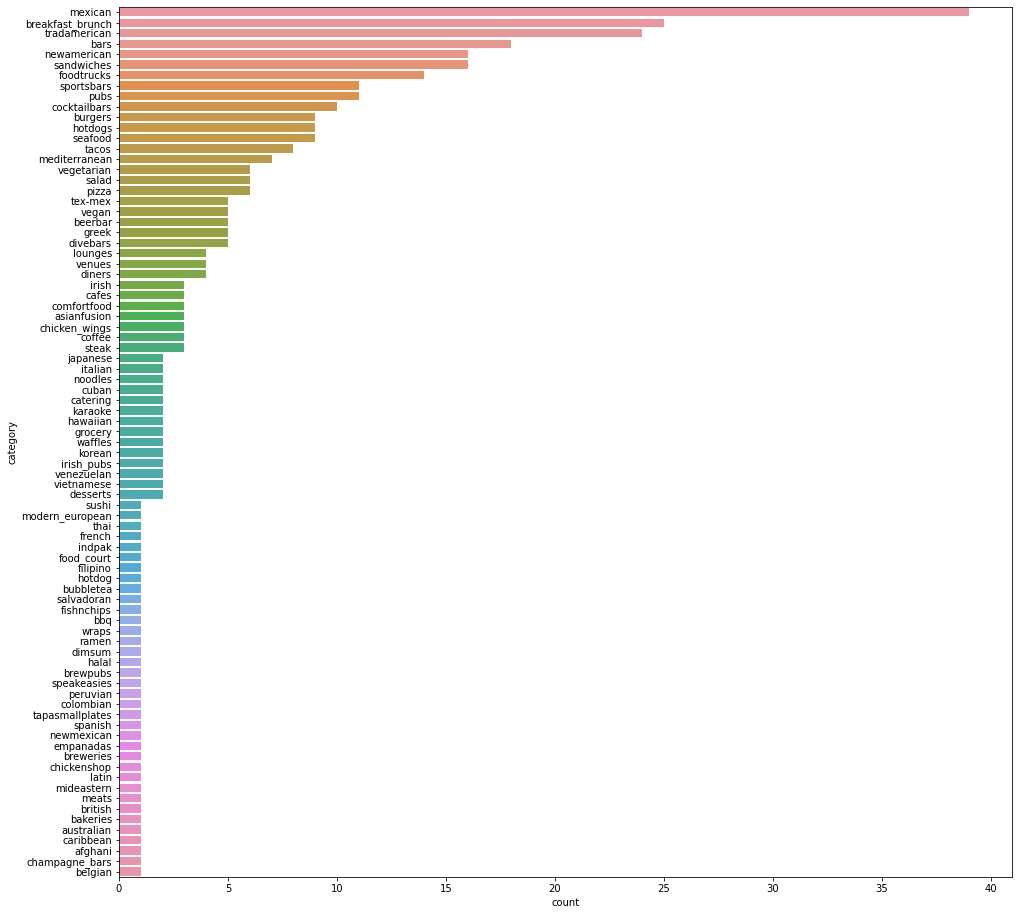

In [7]:
#Plot the count of restaurant categories

f, ax = plt.subplots(figsize=(16,16))

sns.barplot(x="count", y="category", 
            data=df_counter, label="category")

While the highest count of the category field is reasonable ("Mexican"), there are many which, while they may have some tacos on their menu, probably aren't restaurants that users would want to get returned if their primary search keyword is "tacos" (dim sum?? sushi??)

#### Step 2: Add filters based on categorical variables



We will now filter the returned dataset by its categorical variables: price (which here is discrete as "$" ratings), category, or transaction type.

In [8]:
#Filter map based on price

filter_col = "price"
target = "$$"

viz2 = get_viz(file_path, filter_col = filter_col, target = target)

viz2.show()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [9]:
#Filter map based on transaction types

filter_col = "transactions"
target_list = ["delivery"]

viz3 = get_viz(file_path, filter_col = filter_col, target = target_list)

viz3.show()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [10]:
#Filter map based on transaction values

filter_col = "category"
target_list = ["texmex", "tacos", "mexican"]

viz4 = get_viz(file_path, filter_col = filter_col, target = target_list)

viz4.show()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


#### Step 3: Add filters based on ratings

Finally, we can also add filters based on ratings

In [11]:
#Filter map based on rating

filter_col = "rating"
target = 4

viz5 = get_viz(file_path, filter_col=filter_col, target=target, g_than = True)

viz5.show()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


### Visualizing the Review Data

We wanted to also create visualization based on the review text data.

In [12]:
# Setup- get prepared review text

f1 = Path(os.path.join(dir_path, "data", "reviews.csv"))
f2 = Path(os.path.join(dir_path, "data", "reviewCountOnPage.csv"))

reviews = get_latest_reviews(f1, f2)

Preprocess the reviews using following steps: 

1. Lowercase
2. Remove URL
3. Remove Trailing ’s’ and Apostrophe
4. Tokenize Text (NLTK.word_tokenize)
5. Remove Punctuations (including white space)
6. Break Tokens on Non-alpha-numeric Values
7. Lemmatize the Tokens
8. Remove stopwords(NLTK.stopwords (English) and Self-Defined Extra Stopwords) 

Create visualizations for the text reviews including a distribution plot and a wordcloud plot.

In [13]:
# Preprocessing- remove stopwords, rare words

extra_stopwords = set(["wa", "apos", "food", "place"])
SW = set(nltk.corpus.stopwords.words('english'))
stopwords = SW | set(["http", "co", "rt", "amp"]) | extra_stopwords
tokens = preprocess(read_all_reviews(f1), stopwords)
distribution = collections.Counter(tokens)
rare_words_set = get_rare_words(distribution)

In [14]:
counter_df = pd.DataFrame.from_dict(distribution, orient = 'index').rename(columns = {0 : 'count'})

df_t = counter_df.transpose()
df_drop_rare = df_t.drop(columns = rare_words_set).transpose()

In [15]:
# Check rare words

df_drop_rare.sort_values(by = "count")

,count
speechless,2
replacing,2
bullshit,2
coaster,2
brain,2
...,...
one,911
like,1084
time,1091
great,1153


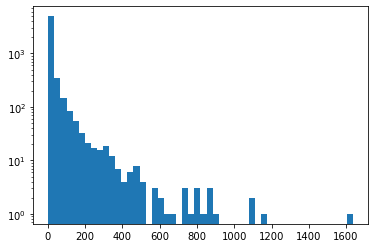

In [16]:
# Plot distribution of words

plt.hist(df_drop_rare["count"], bins=50)
plt.yscale('log')

In [17]:
# Examine words with high frequencies in the reviews

df_lots = df_drop_rare.loc[df_drop_rare["count"] > 200]
df_indexed = df_lots.reset_index().set_index("count")
dict_lots = df_lots.to_dict()
dict_lots= dict_lots['count']

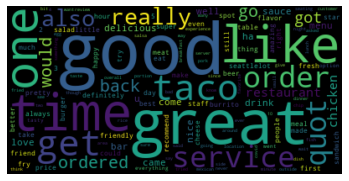

In [18]:
#Get WordCloud of high frequency words

wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=dict_lots)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Next Steps

1. Enable multiple filters on the map
2. Refine the web scraper
3. App UI building (Interactive Dashboard)
4. Machine Learning

Here is a simple example of folium map visualization.

In [19]:
import yelp_reviews
import pandas as pd
import folium

api_key = 'Y0vpAcCzpLY3l5VSChBzAcRpy-JrWmmaOenf'\
                    'Uf-AGrC4lKtc79YDH503ZZSURFVGsAx_I1-Xo'\
                    '0T6YykBPmaOalvnGubVhpIH_K0kfIcWEh0FLftyNyUQ75MXaW0wYHYx'
params={"term":"taco",
                    "location":"University District,Seattle",
                    "categories": "restaurants"}


tacos = yelp_reviews.all_restaurants(api_key,params)
taco_restaurants_df = yelp_reviews.parse_api_response(tacos)


m=folium.Map(location=[47.6498, -122.3038], zoom_start=13, tiles="OpenStreetMap")
restaurant_url_list = taco_restaurants_df['url'].tolist()

for i in range(0,len(taco_restaurants_df)):
    records=taco_restaurants_df.loc[i]
    if((records['rating']==4)and(records['price']=='$')):
        
        folium.CircleMarker(location=[records['latitude'], records['longitude']],
                            radius=(records['rating'])*2,
                            color="crimson",
                            popup=records['name'],
                            fill_color='crimson',
                            fill=True).add_to(m)

m

We would like the ability to filter based on multiple criteria -  as the folium map above.
We initially tried to use this package but liked the support of tooltip better in mapbox

## Lessons Learned

1. Continuous Integration- start early!
2. Viable goals- control and commit to project scope
3. Test early, test often
4. Stay organized- working across different IDEs, working in seperate branches